# Подготовка датасета

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

feature = 'State'
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
target = pd.Series(pd.factorize(df[feature])[0])
df = df.iloc[:, 6:]
for column in df:
    mean = df[column].mean()
    std = df[column].std()
    outliers = np.where((df[column] - mean) / std >= 3)[0]
    df = df.drop(index=outliers).reset_index(drop=True)
    target = target.drop(index=outliers).reset_index(drop=True)

df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)

# Подбор гиперпараметров

In [2]:
import optuna
from knn import KnnClassifier
from sklearn.metrics import accuracy_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

## Для собственной реализации

In [7]:
def my_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    window = trial.suggest_categorical('window', ['fixed', 'unfixed'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'common'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'chebyshev', 'cosine'])
    h, a, b, p = 1, 1, 1, 1
    if window == 'fixed':
        h = trial.suggest_float('h', 1e-2, 1e2, log=True)
    if kernel == 'common':
        a = trial.suggest_int('a', 1, 4)
        b = trial.suggest_int('b', 1, 4)
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KnnClassifier(neighbors, window, h, kernel, a, b, metric, p)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-02-27 14:49:54,394] A new study created in memory with name: no-name-48c4cb82-9793-4fad-a09d-1f771bfea2e4
[I 2024-02-27 15:03:18,726] Trial 0 finished with value: 0.05059433099664736 and parameters: {'neighbors': 4, 'window': 'fixed', 'kernel': 'common', 'metric': 'cosine', 'h': 11.180472965446262, 'a': 3, 'b': 1}. Best is trial 0 with value: 0.05059433099664736.
[I 2024-02-27 15:05:44,253] Trial 1 finished with value: 0.4544346235903688 and parameters: {'neighbors': 5, 'window': 'fixed', 'kernel': 'uniform', 'metric': 'cosine', 'h': 0.029826436225409137}. Best is trial 1 with value: 0.4544346235903688.
[I 2024-02-27 15:14:21,427] Trial 2 finished with value: 0.05059433099664736 and parameters: {'neighbors': 50, 'window': 'fixed', 'kernel': 'gaussian', 'metric': 'chebyshev', 'h': 21.13051969328835}. Best is trial 1 with value: 0.4544346235903688.
[I 2024-02-27 15:19:48,239] Trial 3 finished with value: 0.05059433099664736 and parameters: {'neighbors': 2, 'window': 'fixed', 'ker

{'neighbors': 12, 'window': 'unfixed', 'kernel': 'gaussian', 'metric': 'minkowski', 'p': 1}


## Для реализации sklearn

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine'])
    p = 1
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KNeighborsClassifier(neighbors, weights=weights, metric=metric, p=p, n_jobs=1)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-02-27 14:38:51,424] A new study created in memory with name: no-name-07f470da-5c51-47c0-8ee7-972823ba16f4
[I 2024-02-27 14:38:52,594] Trial 0 finished with value: 0.6330387077110637 and parameters: {'neighbors': 31, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 0 with value: 0.6330387077110637.
[I 2024-02-27 14:39:01,644] Trial 1 finished with value: 0.6461444681499543 and parameters: {'neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski', 'p': 3}. Best is trial 1 with value: 0.6461444681499543.
[I 2024-02-27 14:39:02,404] Trial 2 finished with value: 0.605912831453825 and parameters: {'neighbors': 1, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 1 with value: 0.6461444681499543.
[I 2024-02-27 14:39:03,060] Trial 3 finished with value: 0.5787869551965864 and parameters: {'neighbors': 2, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 1 with value: 0.6461444681499543.
[I 2024-02-27 14:39:04,015] Trial 4 finished with value: 0.620237732398659

{'neighbors': 18, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}


# Зависимость функции качества от числа соседей

In [9]:
neighbors_range = range(1, 51)
size = len(neighbors_range)

my_train_accuracy = [0.0] * size
my_test_accuracy = [0.0] * size
classifier = KnnClassifier(1, window_type='unfixed', kernel='gaussian', metric='minkowski', p=1)
classifier.fit(X_train, y_train)
for neighbors in neighbors_range:
    classifier.neighbors_number = neighbors
    my_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    my_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))
    
sklearn_train_accuracy = [0.0] * size
sklearn_test_accuracy = [0.0] * size
for neighbors in neighbors_range:
    classifier = KNeighborsClassifier(neighbors, weights='distance', metric='minkowski', p=1, n_jobs=1)
    classifier.fit(X_train, y_train)
    sklearn_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    sklearn_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))

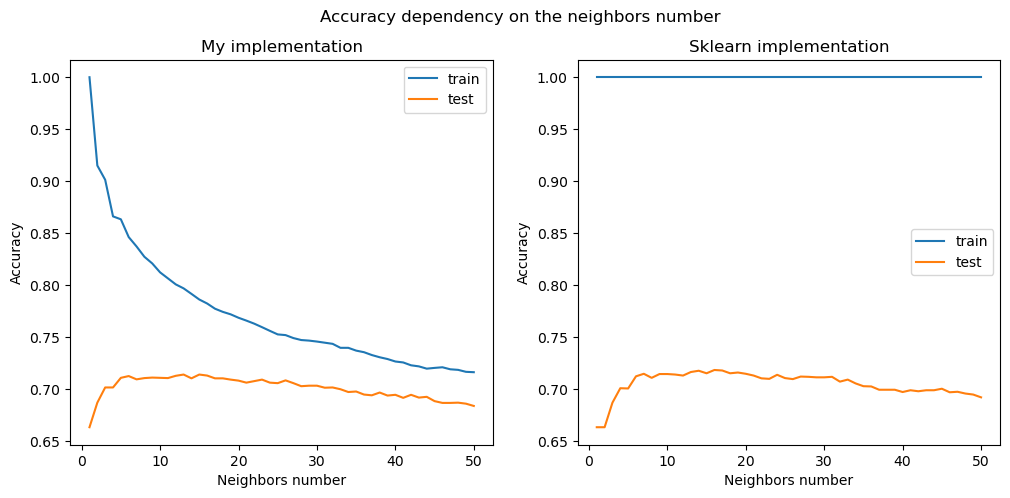

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Accuracy dependency on the neighbors number')
ax[0].set_title('My implementation')
ax[0].set_xlabel('Neighbors number')
ax[0].set_ylabel('Accuracy')
ax[0].plot(neighbors_range, my_train_accuracy, label='train')
ax[0].plot(neighbors_range, my_test_accuracy, label='test')
ax[0].legend()

ax[1].set_title('Sklearn implementation')
ax[1].set_xlabel('Neighbors number')
ax[1].set_ylabel('Accuracy')
ax[1].plot(neighbors_range, sklearn_train_accuracy, label='train')
ax[1].plot(neighbors_range, sklearn_test_accuracy, label='test')
ax[1].legend()

# Взвешивание объектов методом LOWESS

In [2]:
from lowess import Lowess
from knn import KnnClassifier
from sklearn.metrics import accuracy_score

lowess = Lowess(12, knn_kernel='gaussian', lowess_kernel='gaussian', metric='minkowski', p=1)
weights = lowess.get_weights(X_train, y_train)

## Для собственной реализации

In [7]:
classifier = KnnClassifier(12, window_type='unfixed', kernel='gaussian', metric='minkowski', p=1)

classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier.fit(X_train, y_train, weights)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.7147037307973665
После взвешивания:  0.7003169958546696


## Для реализации sklearn

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

oversampled_X_train = X_train.sample(frac=10, replace=True, weights=weights, random_state=42)
oversampled_y_train = y_train.sample(frac=10, replace=True, weights=weights, random_state=42)
classifier = KNeighborsClassifier(18, weights='distance', metric='minkowski', p=1, n_jobs=1)
classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier = KNeighborsClassifier(180, weights='distance', metric='minkowski', p=1, n_jobs=1)
classifier.fit(oversampled_X_train, oversampled_y_train)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.7100707144598878
После взвешивания:  0.7032431114362351
